In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Ahora con feature engineering

In [3]:
# Esta desbalanceado, hay muchos de daño 2 y pocos de daño 1
# Hay que usar scale_pos_weight en el modelo para evitar esto

In [4]:
#Probar train error (fitear y predecir sobre train)
#Comparar con validation error (predecir validation set)

In [5]:
#Si el set de validacion es fijo, los hiperparametros solo seran optimos para ese conjunto de datos
#Para evitar esto, usar k fold CV (k=10 suele ser un buen parametro)

In [6]:
#Feature Engineering
# Features numericos:
#  Hacer binning
#  Features estadisticos 
#  Promedio de X para los K vecinos mas cercanos (KNN -> Hacer mas adelante)
#  Interacciones entre features (cocientes, etc)
# Features categoricos:
#  Ver mas adelante

In [7]:
train = pd.read_pickle('../cleaned_train.pkl')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   building_id                             260601 non-null  int32   
 1   damage_grade                            260601 non-null  int8    
 2   geo_level_1_id                          260601 non-null  int8    
 3   geo_level_2_id                          260601 non-null  int16   
 4   geo_level_3_id                          260601 non-null  int16   
 5   count_floors_pre_eq                     260601 non-null  int8    
 6   age                                     260601 non-null  int16   
 7   area_percentage                         260601 non-null  int8    
 8   height_percentage                       260601 non-null  int8    
 9   land_surface_condition                  260601 non-null  category
 10  foundation_type                 

In [8]:
weights = train.damage_grade.value_counts(normalize=True).mul(100).to_frame()
weights

,damage_grade
2,56.891186
3,33.468022
1,9.640792


In [9]:
weights['weight'] = [1/5.6,1/3.3,1]
weights['weight']

2    0.178571
3    0.303030
1    1.000000
Name: weight, dtype: float64

In [10]:
def label_weight(row):
    if row['damage_grade'] == 1:
        return 1
    if row['damage_grade'] == 2:
        return 1/5.6
    else:
        return 1/3.3

In [11]:
train['weight'] = train.apply(lambda row: label_weight(row), axis=1)
train

,building_id,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,weight
0,802906,3,6,487,12198,2,30,6,5,t,...,False,False,False,False,False,False,False,False,False,0.303030
1,28830,2,8,900,2812,2,10,8,7,o,...,False,False,False,False,False,False,False,False,False,0.178571
2,94947,3,21,363,8973,2,10,5,5,t,...,False,False,False,False,False,False,False,False,False,0.303030
3,590882,2,22,418,10694,2,10,6,5,t,...,False,False,False,False,False,False,False,False,False,0.178571
4,201944,3,11,131,1488,3,30,8,9,t,...,False,False,False,False,False,False,False,False,False,0.303030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,2,25,1335,1621,1,55,6,3,n,...,False,False,False,False,False,False,False,False,False,0.178571
260597,669485,3,17,715,2060,2,0,6,5,t,...,False,False,False,False,False,False,False,False,False,0.303030
260598,602512,3,17,51,8163,3,55,6,7,t,...,False,False,False,False,False,False,False,False,False,0.303030
260599,151409,2,26,39,1851,2,10,14,6,t,...,False,False,False,False,False,False,False,False,False,0.178571


In [12]:
num_cols = train.select_dtypes(include=['number']).columns.to_list()[2:]
num_cols

['geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'area_percentage',
 'height_percentage',
 'count_families',
 'weight']

In [13]:
# altura / cantidad de pisos (altura de los pisos)
# area * altura (volumen)
# binning (0: 0 familias, 1: 1 familia, 2: mas de una familia)

In [14]:
train['floor_height'] = train['height_percentage'] / train['count_floors_pre_eq']
train['volumen_percentage'] = train['height_percentage'] * train['area_percentage']

bins = [0, 1, 2, 10]
labels = [0, 1, 2]
familias = pd.cut(train['count_families'], bins, right=False, labels=labels)
train['count_families'] = pd.to_numeric(familias, downcast="integer")

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 43 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   building_id                             260601 non-null  int32   
 1   damage_grade                            260601 non-null  int8    
 2   geo_level_1_id                          260601 non-null  int8    
 3   geo_level_2_id                          260601 non-null  int16   
 4   geo_level_3_id                          260601 non-null  int16   
 5   count_floors_pre_eq                     260601 non-null  int8    
 6   age                                     260601 non-null  int16   
 7   area_percentage                         260601 non-null  int8    
 8   height_percentage                       260601 non-null  int8    
 9   land_surface_condition                  260601 non-null  category
 10  foundation_type                 

In [15]:
bool_cols = train.select_dtypes(include=['bool']).columns.to_list()
bool_cols

['has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'has_secondary_use',
 'has_secondary_use_agriculture',
 'has_secondary_use_hotel',
 'has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other']

In [16]:
# Concatenar las superestructuras (hay edificios que poseen mas de una)
# Concatenar los usos secundarios y las superestructuras (el daño varia segun la superestructura como mostre
#en el TP1)
# Al encodear estas concatenaciones me parece que hay que encodear como el promedio de datos que poseen esta
#caracteristica (no hacerlo por ahora)

In [17]:
# Concatenacion de superestructuras
superestructuras = bool_cols[:11]
for a in superestructuras:
    for b in superestructuras:
        if a != b:
            train[a+b] = train[a] & train[b]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Columns: 153 entries, building_id to has_superstructure_otherhas_superstructure_rc_engineered
dtypes: bool(132), category(8), float64(2), int16(3), int32(1), int8(7)
memory usage: 45.0 MB


In [18]:
# Concatenacion de usos secundarios y su superestructura
secondary_uses = bool_cols[12:]
for a in secondary_uses:
    for b in superestructuras:
        train[a+b] = train[a] & train[b]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Columns: 263 entries, building_id to has_secondary_use_otherhas_superstructure_other
dtypes: bool(242), category(8), float64(2), int16(3), int32(1), int8(7)
memory usage: 72.3 MB


In [18]:
train.transpose()

,0,1,2,3,4,5,6,7,8,9,...,260591,260592,260593,260594,260595,260596,260597,260598,260599,260600
building_id,802906,28830,94947,590882,201944,333020,728451,475515,441126,989500,...,560805,207683,226421,159555,827012,688636,669485,602512,151409,747594
damage_grade,3,2,3,2,3,2,3,1,2,1,...,3,2,2,2,3,2,3,3,2,3
geo_level_1_id,6,8,21,22,11,8,9,20,0,26,...,20,10,8,27,8,25,17,17,26,21
geo_level_2_id,487,900,363,418,131,558,475,323,757,886,...,368,1382,767,181,268,1335,715,51,39,9
geo_level_3_id,12198,2812,8973,10694,1488,6089,12066,12236,7219,994,...,5980,1903,8613,1537,4718,1621,2060,8163,1851,9101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
has_secondary_use_otherhas_superstructure_timber,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
has_secondary_use_otherhas_superstructure_bamboo,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
has_secondary_use_otherhas_superstructure_rc_non_engineered,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
has_secondary_use_otherhas_superstructure_rc_engineered,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [19]:
cat_cols = train.select_dtypes(include=['category']).columns.to_list()


oneHot = pd.get_dummies(train[cat_cols], prefix=cat_cols)


train = train.drop(columns=cat_cols)


train = pd.concat([train, oneHot], axis=1)


#oneHot = pd.get_dummies(test[cat_cols], prefix=cat_cols)

#test = test.drop(columns=cat_cols)

#test = pd.concat([test, oneHot], axis=1)
y = train.damage_grade
weights = train.weight
X = train.drop(columns=['damage_grade', 'weight'])
X = X.set_index('building_id')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

In [19]:
model = xgb.XGBClassifier()

model.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [20]:
preds = model.predict(X_valid)

preds

array([1, 3, 1, ..., 3, 2, 2], dtype=int8)

In [21]:
score = f1_score(y_valid, preds, average='micro')
print('Validation Score:', score)

Validation Score: 0.6703248210893882


In [22]:
score = f1_score(y_train, model.predict(X_train), average='micro')
print('Train Score:', score)

Train Score: 0.6739207597851112


In [23]:
model = xgb.XGBClassifier()

model.fit(X_train, y_train, sample_weight=weights)

XGBClassifier(objective='multi:softprob')

In [24]:
score = f1_score(y_valid, preds, average='micro')
print('Validation Score:', score)

Validation Score: 0.6703248210893882


In [25]:
score = f1_score(y_train, model.predict(X_train), average='micro')
print('Train Score:', score)

Train Score: 0.6745251343054489


In [ ]:
dtrain = xgb.DMatrix(X_train)


In [20]:
model = xgb.train(xgb.DMatrix(data=X_train, label=y_train, weight = weights))

In [21]:
model.predict(xgb.DMatrix(data=X_valid, label=y_valid)

AttributeError: module 'xgboost' has no attribute 'predict'

In [26]:
cat_cols = train.select_dtypes(include=['category']).columns.to_list()
cat_cols

[]

In [27]:
# Por ahora probamos esto y despues vemos el tema de encontrar las interacciones mas importantes con arboles

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

In [29]:
df = pd.DataFrame(columns=X_train.columns)
df = df.T

In [30]:
df['feature importance'] = model.feature_importances_

In [31]:
top_25_features = df.sort_values('feature importance', ascending=False).head(35)
top_25_features

,feature importance
geo_level_1_id,0.368271
geo_level_2_id,0.094331
age,0.058123
has_superstructure_mud_mortar_stone,0.035255
geo_level_3_id,0.025727
has_superstructure_cement_mortar_brick,0.023821
foundation_type_r,0.021915
other_floor_type_q,0.021915
count_floors_pre_eq,0.020486
has_superstructure_mud_mortar_brick,0.020486


<AxesSubplot:>

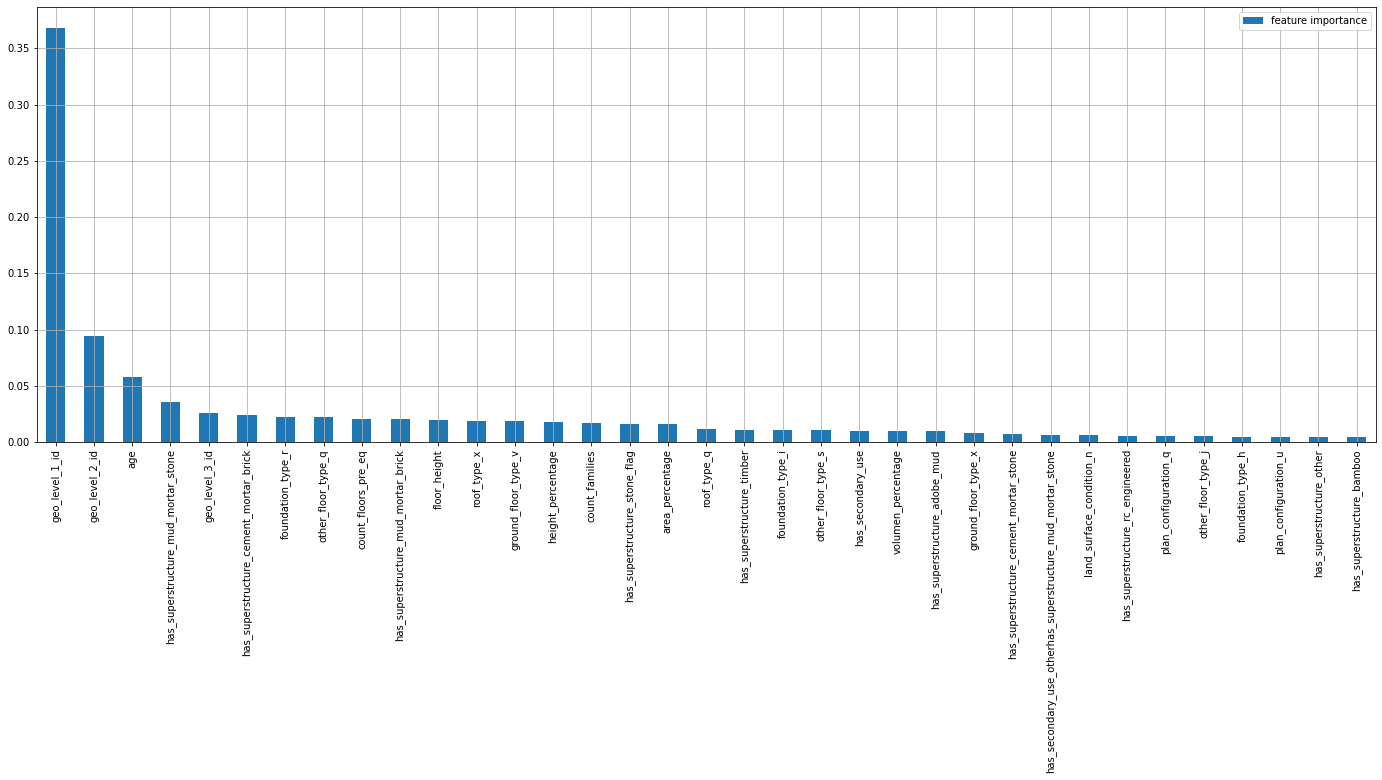

In [32]:
top_25_features.plot.bar(figsize = (24,8), grid=True)